In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from polyglot.text import Text
from datasets import Dataset
import seaborn as sns
from nltk.corpus import stopwords
import pickle
import ast
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity as cosine

/home/caegi/Documents/pandas/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Pandas Final Project - Jean Thomas Fidalgo Cardoso

## 1 Analyzing CommonVoice (20 pts)

### load_data

In [ ]:
languages = ["ar", "de", "en", "es", "fr", "id", "it", "ja", "lg", "ru", "sw", "ta", "tr", "zh-CN"]

duration_df = pd.concat([pd.read_csv(f'metadata/{lg}/cv-corpus-15.0-2023-09-08/{lg}/clip_durations.tsv', sep='\t', on_bad_lines='skip') for lg in languages])
train_df = pd.concat([pd.read_csv(f'metadata/{lg}/cv-corpus-15.0-2023-09-08/{lg}/train.tsv', sep='\t', on_bad_lines='skip') for lg in languages])

df = pd.merge(duration_df, train_df, left_on="clip", right_on="path").rename(columns={"duration[ms]": "duration", "locale": "language", "client_id": "speaker_id"})
df['duration'] = pd.to_timedelta(df['duration'], unit='ms')

### 1. (1 pts) For each language, determine the total duration of recording and the number of different speakers.

In [40]:
df.groupby("language").agg(total_duration=("duration", "sum"), unique_speakers=("speaker_id", "nunique")).reset_index()

,language,total_duration,unique_speakers
0,ar,1 days 08:23:26.304000,23
1,de,37 days 12:54:24.441000,7473
2,en,70 days 08:15:14.520000,36411
3,es,18 days 18:51:28.035000,4682
4,fr,31 days 13:21:27.756000,7159
5,id,0 days 07:40:54.624000,4
6,it,10 days 04:39:41.399000,1323
7,ja,0 days 09:24:30.780000,124
8,lg,4 days 13:45:06.139000,139
9,ru,1 days 13:40:41.885000,283


### 2. (1 pts) For each language and each gender determine the total duration of recordings, the number of different speakers, the average, median, min and max number of recordings per speaker.

In [41]:
# I consider other a gender
df\
    .groupby(["language", "gender"])\
    .agg(
        total_duration=("duration", "sum"),
        unique_speakers=("speaker_id", "nunique"),
        mean_nb_recordings_per_speaker=("speaker_id", lambda x: x.value_counts().mean()),
        median_nb_recording_per_speaker=("speaker_id", lambda x: x.value_counts().median()),
        max_nb_recording_per_speaker=("speaker_id", lambda x: x.value_counts().max()),
        min_nb_recordings_per_speaker=("speaker_id", lambda x: x.value_counts().min())
    )\
    .reset_index()

,language,gender,total_duration,unique_speakers,mean_nb_recordings_per_speaker,median_nb_recording_per_speaker,max_nb_recording_per_speaker,min_nb_recordings_per_speaker
0,ar,female,0 days 05:24:25.680000,9,514.444444,399.0,1286,28
1,ar,male,0 days 04:23:33.060000,11,327.818182,277.0,1174,3
2,de,female,2 days 22:39:14.715000,488,90.971311,24.0,3068,1
3,de,male,21 days 09:39:33.761000,2687,120.864533,20.0,60854,1
4,de,other,0 days 06:42:41.026000,37,126.837838,22.0,2731,1
5,en,female,13 days 23:54:27.471000,2886,72.735967,14.0,9795,1
6,en,male,34 days 04:31:57.782000,9969,52.762062,10.0,47480,1
7,en,other,1 days 12:31:10.358000,310,78.267742,14.0,8137,1
8,es,female,5 days 10:38:40.596000,744,122.939516,21.0,20353,1
9,es,male,10 days 17:57:24.816000,1810,99.922652,18.0,32827,1


### 3. (1 pts) Which language has the highest proportion of recordings by a person in the largest age bracket considered?

In [42]:
df\
    .groupby(["language"])["age"]\
    .value_counts(normalize=True)\
    .reset_index(name="proportion")\
    .query("age == 'nineties'")\
    .loc[lambda res_df: res_df["proportion"] == res_df["proportion"].max()]


,language,age,proportion
57,lg,nineties,0.006918


### 4. (1 pts) Determine the number of different genres considered in the corpus. What is the percentage of recordings for which no genre information is available? Plot the genre distribution (including cases where gender information is not available). Do the same for ages.

<Axes: ylabel='count'>

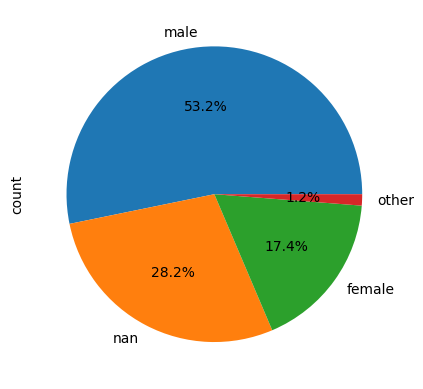

In [43]:
df["gender"].value_counts(dropna=False)\
    .plot(kind="pie", autopct='%1.1f%%')

28.2% of recordings have no gender information

<Axes: ylabel='count'>

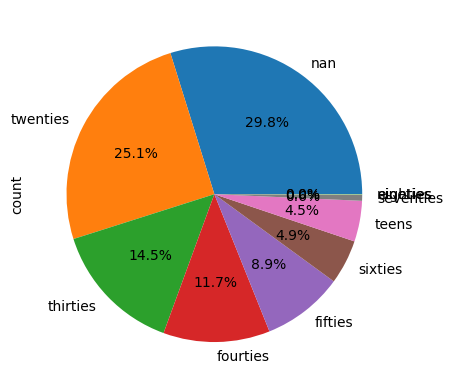

In [44]:
df["age"].value_counts(dropna=False)\
    .plot(kind="pie", autopct='%1.1f%%')

29.8% of recordings have no age information

### 5. (2 pts) Find out for each language and each genre the 7 speakers who produced the most recordings.

In [46]:
top_counts_df = df.groupby(["language", "gender"])["speaker_id"]\
    .value_counts()\
    .groupby(level=[0, 1])\
    .nlargest(7)\
    .droplevel([0, 1])\
    .reset_index()

Only showing one language or else it's very long

In [47]:
top_counts_df[top_counts_df["language"] == "ja"].query("gender == 'female'")

,language,gender,speaker_id,count
118,ja,female,02a8841a00d762472a4797b56ee01643e8d9ece5a225f2...,1147
119,ja,female,b7163b95f7dfc60b56cea7b0f7e9ab23f80b52635b2982...,59
120,ja,female,ff081943570e19f8b572d60234b853a6a489755e72ece7...,32
121,ja,female,e12139e647fa79ca64b07117a6f35ce52c09f0866b3071...,26
122,ja,female,d072877fd177b0ab54a48c42d09b00231aa29fa00418dd...,21
123,ja,female,ccc6a911d793d2db23a00a3366b0a34e7631704c411745...,20
124,ja,female,5fc38e48d254e4a4a5982bf82aefe09243b92f91bc0227...,13


In [48]:
top_counts_df[top_counts_df["language"] == "ja"].query("gender == 'male'")

,language,gender,speaker_id,count
125,ja,male,3447120ac93b7c7788687c259b7f55058804e4982c3617...,2758
126,ja,male,3c9d94093b88b178118bb3be8de72d64c0423a0b8e32bf...,1190
127,ja,male,11e6ed343ee4fcf30f8717b698eca87944399ff5e73b32...,80
128,ja,male,51e9ed35447037faf8743d586cdb3e1ec9f5c36145456d...,70
129,ja,male,7704f48f32982108d0854a4a32eb4793e274ac0ab71ba9...,68
130,ja,male,15a8f857a9dfa5daeabb2e63cf74928f9331b420722119...,62
131,ja,male,97f38629e8a34c2f19bdaee6b6a33e1a2ef51f27df3cb7...,61


In [49]:
top_counts_df[top_counts_df["language"] == "ja"].query("gender == 'other'")

,language,gender,speaker_id,count
132,ja,other,397d4d8526a74d582e018bfa9adb687127eefc5a039c14...,17


### 6. (3 pts) For each language, create a 1-hour test set and a training set as large as possible, ensuring that speakers from the test set do not appear in the training set.

In [50]:
df['cumulative_duration[seconds]'] = (df.groupby('language')['duration'].transform(lambda x: x.dt.total_seconds().cumsum()))
df.loc[df["cumulative_duration[seconds]"] < 3600, ["dataset_type_q6"]] = "test"
df.loc[~df["speaker_id"].isin(df[df["dataset_type_q6"] == "test"]["speaker_id"]), ["dataset_type_q6"]] = "train"

### 7. (1 pts) How many languages have more female than male recordings?

In [13]:
df\
    .groupby(["language"])\
    ["gender"].value_counts()\
    .reset_index()\
    .pivot(index='language', columns='gender', values='count')\
    .reset_index()\
    .rename(columns={"female":"female_recordings_count", "male":"male_recordings_count", "other":"other_recordings_count"})\
    .query("female_recordings_count > male_recordings_count")

gender,language,female_recordings_count,male_recordings_count,other_recordings_count
0,ar,4630.0,3606.0,NaN
8,lg,32626.0,18466.0,NaN
10,sw,15542.0,11815.0,NaN
11,ta,9759.0,5585.0,NaN


There are 4 languages that have more female recordings

### 8. (3 pts) For each language, create a train set containing 1 hour of recordings and a 10-minute test set so that : i) train and test are gender-balanced ii) the train and test speakers are different

In [14]:
# for me a balanced gender set is a set with equivalent total duration, I did not remove duplicate speakers since I did not want to lose data
df.loc[df["gender"] == "male", ['male_cumulative_duration[seconds]']] = df.loc[df["gender"] == "male"].groupby('language')['duration'].transform(lambda x: x.dt.total_seconds().cumsum())
df.loc[df["gender"] == "female", ['female_cumulative_duration[seconds]']] = df.loc[df["gender"] == "female"].groupby('language')['duration'].transform(lambda x: x.dt.total_seconds().cumsum())
df.loc[df.apply(lambda r: r["male_cumulative_duration[seconds]"] < 1800 or r["female_cumulative_duration[seconds]"] < 1800, axis=1), ["dataset_type_q8"]] = "train" # 1800 seconds for male, 1800 seconds for female: 3600 seconds(1h) for train set

filtered_df = df[~(df["speaker_id"].isin(df[df["dataset_type_q8"] == "train"]["speaker_id"]))]
filtered_df.loc[filtered_df["gender"] == "male", ['male_cumulative_duration[seconds]']] = filtered_df.loc[filtered_df["gender"] == "male"].groupby('language')['duration'].transform(lambda x: x.dt.total_seconds().cumsum())
filtered_df.loc[filtered_df["gender"] == "female", ['female_cumulative_duration[seconds]']] = filtered_df.loc[filtered_df["gender"] == "female"].groupby('language')['duration'].transform(lambda x: x.dt.total_seconds().cumsum())
filtered_df.loc[filtered_df.apply(lambda r: r["male_cumulative_duration[seconds]"] < 300 or r["female_cumulative_duration[seconds]"] < 300, axis=1), ["dataset_type_q8"]] = "test" # 300 seconds for male, 300 seconds for female: 600 seconds(10min) for test set

In [15]:
train_set = df[df["dataset_type_q8"] == "train"]
test_set = filtered_df[filtered_df["dataset_type_q8"] == "test"]

In [16]:
# example of english
train_en = train_set[train_set["language"] == "en"].copy() 

train_en["cumulative_duration"] = train_en.groupby('language')['duration'] \
    .transform(lambda x: x.dt.total_seconds().cumsum())

train_en["seconds"] = train_en.groupby('language')['duration'] \
    .transform(lambda x: x.dt.total_seconds())

print(train_en["cumulative_duration"], "\n")
print(train_en.groupby("gender")["seconds"].sum().reset_index())

596400       4.248
596401       7.848
596403      12.960
596405      15.336
596407      20.736
            ...   
597953    3566.192
597955    3571.808
597958    3576.488
597961    3582.716
597966    3589.052
Name: cumulative_duration, Length: 631, dtype: float64 

   gender   seconds
0  female  1793.969
1    male  1795.083


In [17]:
# example of english
test_en = test_set[test_set["language"] == "en"].copy() 

test_en["cumulative_duration[seconds]"] = test_en.groupby('language')['duration'] \
    .transform(lambda x: x.dt.total_seconds().cumsum())

test_en["seconds"] = test_en.groupby('language')['duration'] \
    .transform(lambda x: x.dt.total_seconds())

print(test_en["cumulative_duration[seconds]"], "\n")
print(test_en.groupby("gender")["seconds"].sum().reset_index())

597075      6.948
597079     12.444
597080     21.804
597084     27.816
597085     33.192
           ...   
598361    575.508
598364    582.420
598383    587.244
598389    591.996
598398    596.244
Name: cumulative_duration[seconds], Length: 107, dtype: float64 

   gender  seconds
0  female  297.804
1    male  298.440


In [18]:
# example of japanese
test_ja = test_set[test_set["language"] == "ja"].copy() 

test_ja["cumulative_duration[seconds]"] = test_ja.groupby('language')['duration'] \
    .transform(lambda x: x.dt.total_seconds().cumsum())

test_ja["seconds"] = test_ja.groupby('language')['duration'] \
    .transform(lambda x: x.dt.total_seconds())

print(test_ja["cumulative_duration[seconds]"], "\n")
print(test_ja.groupby("gender")["seconds"].sum().reset_index())

2677012      6.804
2677053     11.052
2677075     14.652
2677102     20.448
2677122     27.828
            ...   
2681688    342.000
2682234    347.580
2682347    351.180
2683036    356.796
2683230    361.512
Name: cumulative_duration[seconds], Length: 68, dtype: float64 

   gender  seconds
0  female   61.884
1    male  299.628


For some languages like japanese doing this is impossible since there is not enough data to ensure the train and test sets are gender-balanced and the train and test speakers are different

### 9. (2 pts) Plot, for each language, a box plot representing the distribution of the number of words per sentence.

In [19]:
# save memory
del duration_df, filtered_df, languages, test_en, test_ja, test_set, top_counts_df, train_df, train_en, train_set

In [20]:
df.columns

Index(['clip', 'duration', 'speaker_id', 'path', 'sentence', 'up_votes',
       'down_votes', 'age', 'gender', 'accents', 'variant', 'language',
       'segment', 'cumulative_duration[seconds]', 'dataset_type_q6',
       'male_cumulative_duration[seconds]',
       'female_cumulative_duration[seconds]', 'dataset_type_q8'],
      dtype='object')

In [21]:
import logging
logging.getLogger('polyglot').setLevel(logging.ERROR) # remove annoying warning

def tokenize_sentence(batch):
    batch['tokenized_sentence'] = [[str(word) for word in Text(sentence).words] for sentence in batch['sentence']]
    return batch

dataset = Dataset.from_pandas(df)
dataset = dataset.map(tokenize_sentence, batched=True)
df = dataset.to_pandas()

Map: 100%|██████████| 2924369/2924369 [02:30<00:00, 19471.46 examples/s]


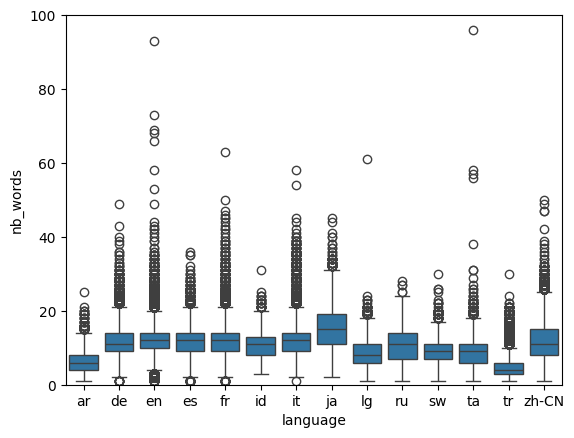

In [ ]:
# only showing values of nb_words < 100
sns.boxplot(data=df, x="language", y="nb_words")
plt.ylim(0, 100) 
plt.show()


### 10. (3 pts) For each language, find the 17 most frequent words after having removed stop words.

In [ ]:
stopwords_in_nltk_l = ["arabic", "german", "english", "spanish", "french", "indonesian", "italian", "russian", "swedish", "turkish", "chinese"]
iso_code_l = ["ar", "de", "en", "es", "fr", "id", "it", "ru", "sw", "tr", "zh-CN"] 
ja_stopwords = ["は", "が", "に", "の", "を", "で", "と", "た", "て", "する", "な", "ある", "これ", "それ", "あの", "この", "どの", "です", "ます", "いる"]
lg_stopwords = ["nze", "gwe", "ye", "ffe", "mwe", "bo", "ya", "zzi", "si", "nga", "buli", "wa", "bu", "ba", "ani", "oba", "oba", "ne", "kubi", "era"]
ta_stopwords = ["மற்றும்", "ஆனால்", "இது", "நீங்கள்", "நான்", "அவன்", "அவள்", "என்று", "எங்கள்", "அவர்கள்", "அவை", "எங்கே", "இதே", "தான்", "இதை", "அல்லது", "போன்ற", "ஏன்", "இங்கே", "அது"]

In [ ]:
for i in range(len(iso_code_l)):
    df.loc[df["language"] == iso_code_l[i], ["no_stop_words_sentence"]] = df.loc[df["language"] == iso_code_l[i]]["tokenized_sentence"].apply(lambda x: [word for word in list(x) if word.lower() not in set(stopwords.words(stopwords_in_nltk_l[i]))])
    
df.loc[df["language"] == "ja", ["no_stop_words_sentence"]] = df.loc[df["language"] == "ja"]["tokenized_sentence"].apply(lambda x: [word for word in list(x) if word.lower() not in set(ja_stopwords)])
df.loc[df["language"] == "lg", ["no_stop_words_sentence"]] = df.loc[df["language"] == "lg"]["tokenized_sentence"].apply(lambda x: [word for word in list(x) if word.lower() not in set(lg_stopwords)])
df.loc[df["language"] == "ta", ["no_stop_words_sentence"]] = df.loc[df["language"] == "ta"]["tokenized_sentence"].apply(lambda x: [word for word in list(x) if word.lower() not in set(ta_stopwords)])

In [ ]:
# df.to_csv("stopwords.csv", index=False)
df = pd.read_csv("stopwords.csv")
# df["no_stop_words_sentence"] = df["no_stop_words_sentence"].apply(ast.literal_eval) # converters in pd.read_csv did not work

/tmp/ipykernel_18476/1074649415.py:2: DtypeWarning: Columns (9,10,17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("stopwords.csv")


In [ ]:
df.explode("no_stop_words_sentence")\
    .query('no_stop_words_sentence not in [".", ",", \'"\', "-", "؟", "。", "、", "・", "?", "!", "，"]')\
    .groupby(["language", "no_stop_words_sentence"])\
    .size()\
    .reset_index(name="count")\
    .sort_values("count", ascending=False)\
    .groupby("language")\
    .first()\
    .reset_index()

,language,no_stop_words_sentence,count
0,ar,سامي,1613
1,de,wurde,37004
2,en,also,66394
3,es,dos,7779
4,fr,a,33944
5,id,memiliki,188
6,it,due,5159
7,ja,した,1871
8,lg,mu,20181
9,ru,это,1221


### 11. (2 pts) Compute, for each language, the size of the available data both in term of duration and in terms of number of words.

In [10]:
df['duration'] = pd.to_timedelta(df['duration'])
df.groupby("language").agg(total_duration=("duration", "sum"), nb_words=("nb_words", "sum")).reset_index()

,language,total_duration,nb_words
0,ar,1 days 08:23:26.304000,178928
1,de,37 days 12:54:24.441000,6292601
2,en,70 days 08:15:14.520000,12734538
3,es,18 days 18:51:28.035000,3578035
4,fr,31 days 13:21:27.756000,6146897
5,id,0 days 07:40:54.624000,54177
6,it,10 days 04:39:41.399000,1902280
7,ja,0 days 09:24:30.780000,114137
8,lg,4 days 13:45:06.139000,656355
9,ru,1 days 13:40:41.885000,273620


## 2 Assessing the variability of wav2vec2 representations (10 pts)

In [3]:
with open("exo2_small.pkl", "rb") as f:
    df = pickle.load(f)

/tmp/ipykernel_3601/4228959544.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df = pickle.load(f)


### 12. (4 pts) Explain each instruction of the manatee function.

In [4]:
def manatee(cow, yak, pelican, slug):

    # cow is a row of the dataframe(aka a series), and this line of code converts it to a dataframe. 
    # It acesses the column T and turns the column into a dataframe. It then copies it
    cow = cow.to_frame().T.reset_index().copy()

    # cow[[yak]]: creates a dataframe containing only the column yak(words)
    # explode the list of intervals in yak
    # add to each row the minTime, the maxTime, and the mark of the interval
    butterfly = cow[[yak]].explode(column=yak)\
         .apply(lambda x: {
                "mussel": x[yak].minTime,
                "end_time": x[yak].maxTime,
                "annotation": x[yak].mark.strip().replace(".", ""),
                },
                axis=1,
                result_type="expand",
            )
    
    
    # create a dataframe with only the column pelican(layer_24) and 
    # explode the list of numpy arrays inside of the column pelican
    crane_fly = cow[[pelican]].explode(column=pelican)
    # add a column leaf barnacle and assign it the variable slug(sampling rate)
    crane_fly["leaf_barnacle"] = slug
    # get the beginning of the signal of the i.th frame: 1/49 * (i-1)
    crane_fly["leaf_barnacle"] = crane_fly["leaf_barnacle"].cumsum() - slug

    # add information from cow back to crane_fly
    crane_fly["speaker"] = cow["speaker"]
    crane_fly["filename"] = cow["filename"]
    crane_fly["sentence"] = cow["sentence"]
    crane_fly["gender"] = cow["gender"]
    
    # merge crane_fly and butterfly on the rows 
    # where leaf_barnacle(beginning of the signal) == mussel(the beginning of the word annotation)
    # or the row in butterfly with the closest inferior mussel compared to leaf_barnacle in crane_fly
    # to align the word annotations and the wav2vec2 representations
    return pd.merge_asof(crane_fly, butterfly, left_on="leaf_barnacle", right_on="mussel")

### 13. (1 pts) Using the manatee function, create a data frame that, for each utterance of a word in the corpus, includes : the word, the speaker and their gender, and a matrix corresponding to the representation on the last layer of this utterance predicted by wav2vec2. This matrix should have dimensions of number of frames ×1,024.

In [6]:
df.iloc[0]

filename                      /data/gwisniew/maxime/FRcorp/corpus/DD/dd_rus_...
layer_24                      [[-0.039639957, 0.1330243, 0.1184451, -0.03256...
speaker                                                                      DD
L1                                                                          rus
age                                                                          25
gender                                                                        f
level                                                                     B2/C1
numeric level                                                               4,5
dur (notrim)                                                              282,0
dur (trimmed)                                                             192,6
speech ratio (top_db=17.5)                                                 0,68
words                         (Interval(0.0, 0.54, None), Interval(0.54, 0.7...
phones                        (Interval(

In [5]:
df_l = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    d = manatee(row, yak="words", pelican="layer_24", slug=1/49)
    d = d[d["annotation"] != ""] 

    matrix_df = d.groupby("annotation")["layer_24"]\
        .apply(lambda x: np.stack(x.values))\
        .reset_index(name="matrix")
    
    matrix_df["speaker"] = d.iloc[0]["speaker"]
    matrix_df["gender"] = d.iloc[0]["gender"]
    
    df_l.append(matrix_df)

100%|██████████| 741/741 [00:05<00:00, 129.13it/s]


In [9]:
d[d["annotation"] == "dis"]

,layer_24,leaf_barnacle,speaker,filename,sentence,gender,mussel,end_time,annotation
24,"[-0.033770762, 0.233388, 0.006062762, -0.01107...",0.489796,DD,/data/gwisniew/maxime/FRcorp/corpus/DD/dd_rus_...,dis tsarine trois fois,f,0.48,0.71,dis
25,"[-0.033328, 0.2321926, 0.009524239, -0.0103112...",0.510204,DD,/data/gwisniew/maxime/FRcorp/corpus/DD/dd_rus_...,dis tsarine trois fois,f,0.48,0.71,dis
26,"[-0.029440917, 0.23098093, 0.004408239, -0.011...",0.530612,DD,/data/gwisniew/maxime/FRcorp/corpus/DD/dd_rus_...,dis tsarine trois fois,f,0.48,0.71,dis
27,"[-0.02990903, 0.22989804, 0.0063279583, -0.012...",0.551020,DD,/data/gwisniew/maxime/FRcorp/corpus/DD/dd_rus_...,dis tsarine trois fois,f,0.48,0.71,dis
28,"[-0.03166809, 0.23020399, 0.0062093628, -0.012...",0.571429,DD,/data/gwisniew/maxime/FRcorp/corpus/DD/dd_rus_...,dis tsarine trois fois,f,0.48,0.71,dis
29,"[-0.030593297, 0.23142834, 0.004898678, -0.012...",0.591837,DD,/data/gwisniew/maxime/FRcorp/corpus/DD/dd_rus_...,dis tsarine trois fois,f,0.48,0.71,dis
30,"[-0.03158626, 0.23156503, 0.0046787797, -0.012...",0.612245,DD,/data/gwisniew/maxime/FRcorp/corpus/DD/dd_rus_...,dis tsarine trois fois,f,0.48,0.71,dis
31,"[-0.031228168, 0.23216575, 0.0040094214, -0.01...",0.632653,DD,/data/gwisniew/maxime/FRcorp/corpus/DD/dd_rus_...,dis tsarine trois fois,f,0.48,0.71,dis
32,"[-0.030663813, 0.23234388, 0.003695903, -0.011...",0.653061,DD,/data/gwisniew/maxime/FRcorp/corpus/DD/dd_rus_...,dis tsarine trois fois,f,0.48,0.71,dis
33,"[-0.03520842, 0.22655982, 0.006928728, -0.0113...",0.673469,DD,/data/gwisniew/maxime/FRcorp/corpus/DD/dd_rus_...,dis tsarine trois fois,f,0.48,0.71,dis


In [7]:
matrix_df

,annotation,matrix,speaker,gender
0,dis,"[[-0.033770762, 0.233388, 0.006062762, -0.0110...",DD,f
1,fois,"[[-0.028272066, 0.23519772, 0.00573691, -0.012...",DD,f
2,trois,"[[-0.033147573, 0.24405561, 0.005307552, -0.01...",DD,f
3,tsarine,"[[-0.030458575, 0.2325051, 0.004186794, -0.011...",DD,f


In [11]:
word_df = pd.concat(df_l)

### 14. (4 pts) Compute the DTW distances between all pairs of utterances of the same word. A function to compute this distance can be downloaded from the lecture page. To compute this distance, for each word, create all pairs of representations, compute the cosine distance between the frames of these two representations (i.e. if the two representations are of size n ×1,024 and m ×1,024, the resulting distance matrix will have a size of n ×m), and then compute the DTW from the resulting distance matrix.

In [12]:
pairs = pd.merge(word_df, word_df, on="annotation", suffixes=["_1", "_2"])
pairs = pairs[pairs.apply(lambda row: not(np.array_equal(row["matrix_1"], row["matrix_2"])), axis=1)]

In [15]:
pairs

,annotation,matrix_1,speaker_1,gender_1,matrix_2,speaker_2,gender_2
1,dis,"[[-0.035875946, 0.22794272, 0.0068324027, -0.0...",DD,f,"[[-0.039717678, 0.24886176, 0.020261437, -0.01...",AB,f
2,dis,"[[-0.035875946, 0.22794272, 0.0068324027, -0.0...",DD,f,"[[-0.03202784, 0.20471953, 0.0014146094, -0.01...",MM,f
3,dis,"[[-0.035875946, 0.22794272, 0.0068324027, -0.0...",DD,f,"[[-0.030241944, 0.22502457, 0.0029568588, -0.0...",AR,m
4,dis,"[[-0.035875946, 0.22794272, 0.0068324027, -0.0...",DD,f,"[[-0.032904427, 0.21405803, 0.002723322, -0.01...",YC,f
5,dis,"[[-0.035875946, 0.22794272, 0.0068324027, -0.0...",DD,f,"[[-0.031570636, 0.20845065, 0.0024545486, -0.0...",AG,m
...,...,...,...,...,...,...,...
1466031,tsarine,"[[-0.030458575, 0.2325051, 0.004186794, -0.011...",DD,f,"[[-0.032001913, 0.20633642, 0.002069901, -0.01...",AG,m
1466032,tsarine,"[[-0.030458575, 0.2325051, 0.004186794, -0.011...",DD,f,"[[-0.032599736, 0.20801976, 0.0020381885, -0.0...",AG,m
1466033,tsarine,"[[-0.030458575, 0.2325051, 0.004186794, -0.011...",DD,f,"[[-0.03327865, 0.20474009, 0.0025241259, -0.01...",AB,f
1466034,tsarine,"[[-0.030458575, 0.2325051, 0.004186794, -0.011...",DD,f,"[[-0.03201539, 0.20773509, 0.0023589728, -0.01...",KL,m


In [8]:
pairs["dist_matrix"] = pairs.apply(lambda row: cosine(row["matrix_1"],row["matrix_2"]), axis=1)

In [9]:
def dtw(dist_mat):
    """
    Find minimum-cost path through matrix `dist_mat` using dynamic programming.

    The cost of a path is defined as the sum of the matrix entries on that
    path. See the following for details of the algorithm:

    - http://en.wikipedia.org/wiki/Dynamic_time_warping
    - https://www.ee.columbia.edu/~dpwe/resources/matlab/dtw/dp.m

    The notation in the first reference was followed, while Dan Ellis's code
    (second reference) was used to check for correctness. Returns a list of
    path indices and the cost matrix.
    """

    N, M = dist_mat.shape
    
    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return {"path": path[::-1],
            "cost_mat": cost_mat,
            "cost": cost_mat[-1, -1]}

In [10]:
pairs["dtw"] = pairs["dist_matrix"].apply(dtw)

### 15. (1 pts) Plot the distribution of distances for each word, distinguishing between cases where the two utterances were spoken by the same person and those where the speakers were different. What can you conclude? Figure 2 gives you an overview of the plot you should generate.

In [51]:
pairs["is_same_speaker"] = pairs.apply(lambda row: row["speaker_1"] == row["speaker_2"], axis=1)
pairs["cost"] = pairs["dtw"].apply(lambda x: x["cost"])

some examples

<Axes: title={'center': 'cost'}, xlabel='[annotation, is_same_speaker]'>

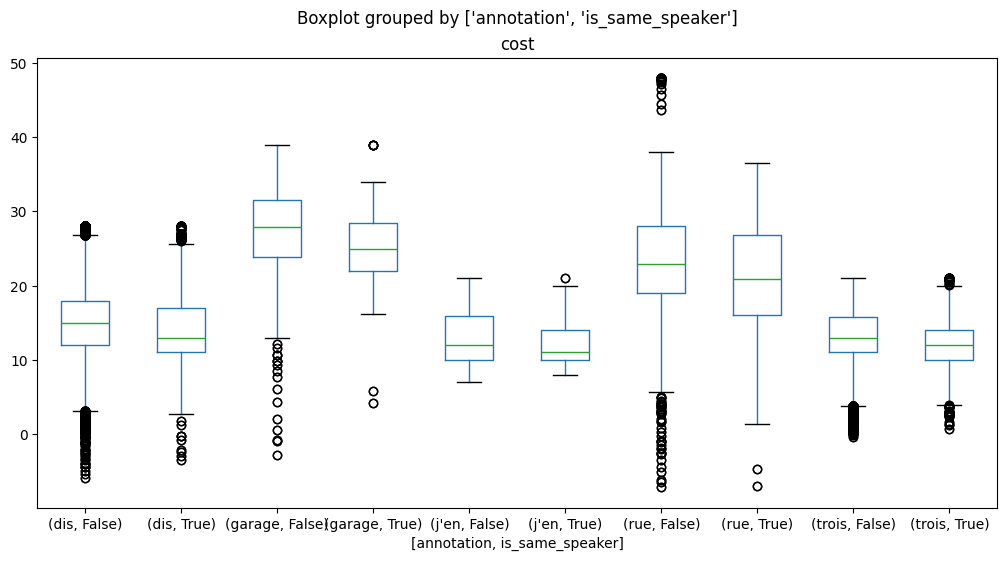

In [54]:
d = pairs[pairs["annotation"].apply(lambda x: x in {"dis","trois","garage","rue","j'en"})]
d.boxplot(column="cost", by=["annotation", "is_same_speaker"], grid=False, figsize=(12, 6))